# [E20] Segmentation Map

In [27]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))


number of train examples : 1000


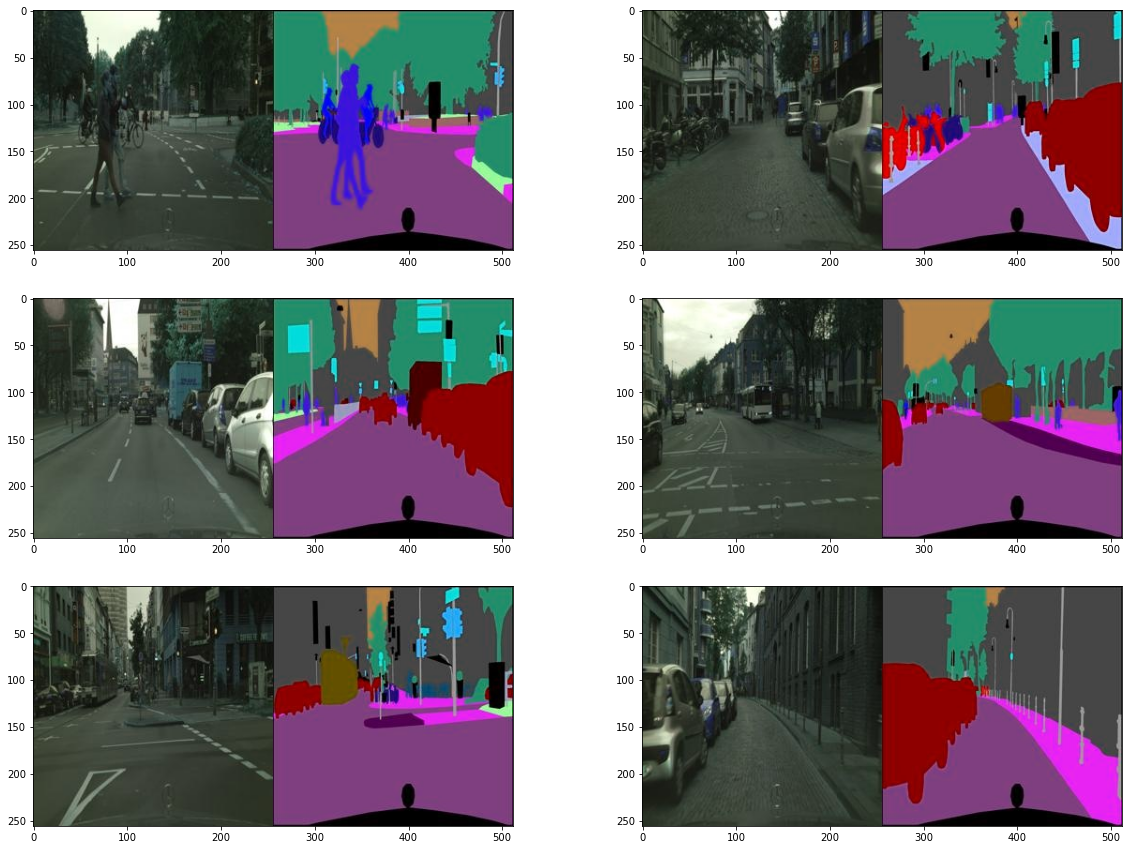

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [29]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)


(256, 512, 3)


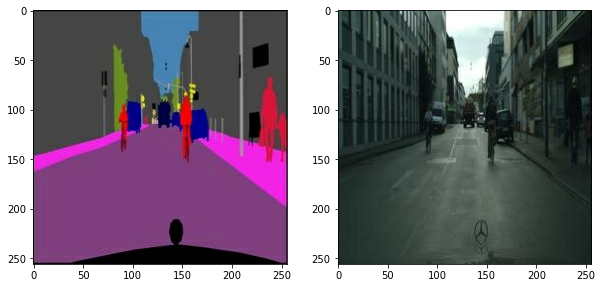

In [36]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))


In [37]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")


✅


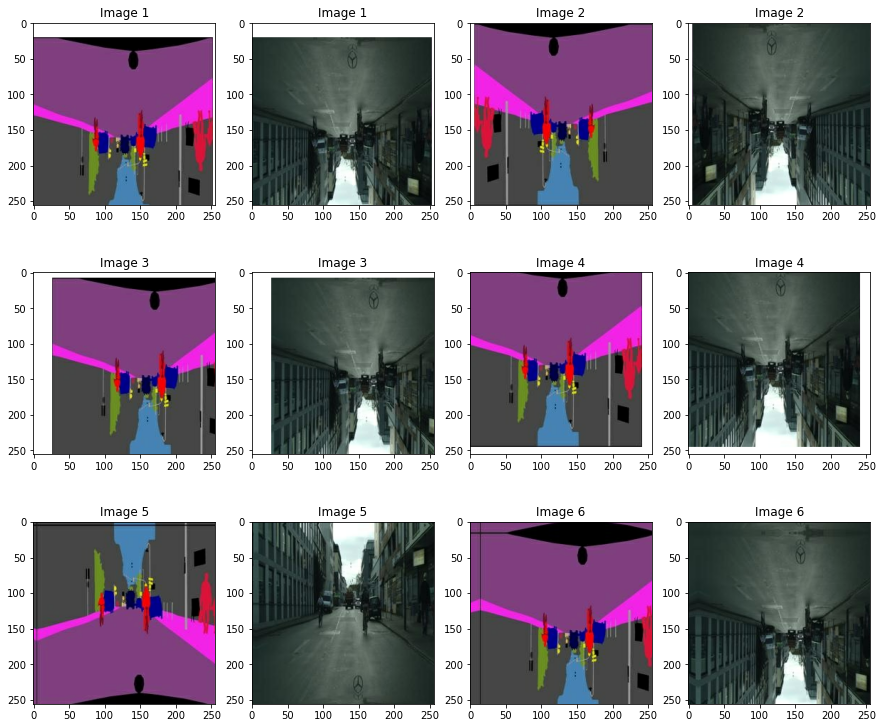

In [38]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

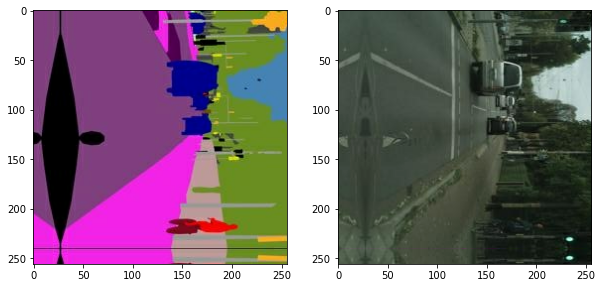

In [39]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [40]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")


✅


In [41]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [42]:
Encoder().get_summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

In [43]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")


✅


In [44]:
Decoder().get_summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

In [45]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [46]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [47]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [48]:
UNetGenerator().get_summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

# Discriminator

In [49]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")


✅


In [50]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [51]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")


✅


In [52]:
Discriminator().get_summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]      

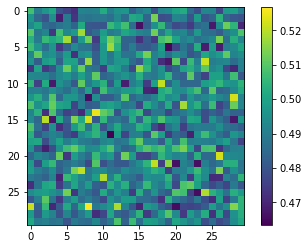

In [53]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# Learning and Test

In [54]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [55]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [56]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")


✅


In [57]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")


EPOCH[1] - STEP[10]                     
Generator_loss:0.8766                     
L1_loss:0.3342                     
Discriminator_loss:1.3020

EPOCH[1] - STEP[20]                     
Generator_loss:0.9952                     
L1_loss:0.2974                     
Discriminator_loss:1.3311

EPOCH[1] - STEP[30]                     
Generator_loss:0.7972                     
L1_loss:0.1818                     
Discriminator_loss:1.3114

EPOCH[1] - STEP[40]                     
Generator_loss:0.8810                     
L1_loss:0.1863                     
Discriminator_loss:1.3672

EPOCH[1] - STEP[50]                     
Generator_loss:0.9094                     
L1_loss:0.1780                     
Discriminator_loss:1.2702

EPOCH[1] - STEP[60]                     
Generator_loss:0.8654                     
L1_loss:0.2395                     
Discriminator_loss:1.1694

EPOCH[1] - STEP[70]                     
Generator_loss:0.9517                     
L1_loss:0.1826                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.6907                     
L1_loss:0.1936                     
Discriminator_loss:0.9718

EPOCH[3] - STEP[80]                     
Generator_loss:2.0265                     
L1_loss:0.1776                     
Discriminator_loss:0.5277

EPOCH[3] - STEP[90]                     
Generator_loss:0.7411                     
L1_loss:0.1890                     
Discriminator_loss:1.1392

EPOCH[3] - STEP[100]                     
Generator_loss:0.9746                     
L1_loss:0.1953                     
Discriminator_loss:0.8888

EPOCH[3] - STEP[110]                     
Generator_loss:1.0701                     
L1_loss:0.1869                     
Discriminator_loss:0.9877

EPOCH[3] - STEP[120]                     
Generator_loss:1.1668                     
L1_loss:0.1840                     
Discriminator_loss:0.8125

EPOCH[3] - STEP[130]                     
Generator_loss:1.4762                     
L1_loss:0.1704                

EPOCH[5] - STEP[130]                     
Generator_loss:1.0241                     
L1_loss:0.1851                     
Discriminator_loss:0.9628

EPOCH[5] - STEP[140]                     
Generator_loss:1.1503                     
L1_loss:0.1849                     
Discriminator_loss:1.1334

EPOCH[5] - STEP[150]                     
Generator_loss:2.3078                     
L1_loss:0.1563                     
Discriminator_loss:2.7789

EPOCH[5] - STEP[160]                     
Generator_loss:2.3673                     
L1_loss:0.1641                     
Discriminator_loss:1.2041

EPOCH[5] - STEP[170]                     
Generator_loss:1.1686                     
L1_loss:0.2120                     
Discriminator_loss:0.4593

EPOCH[5] - STEP[180]                     
Generator_loss:2.2161                     
L1_loss:0.1523                     
Discriminator_loss:1.2868

EPOCH[5] - STEP[190]                     
Generator_loss:1.5419                     
L1_loss:0.1897             

EPOCH[7] - STEP[190]                     
Generator_loss:1.4418                     
L1_loss:0.1877                     
Discriminator_loss:0.5795

EPOCH[7] - STEP[200]                     
Generator_loss:2.0516                     
L1_loss:0.2032                     
Discriminator_loss:0.5312

EPOCH[7] - STEP[210]                     
Generator_loss:1.2131                     
L1_loss:0.1665                     
Discriminator_loss:0.8395

EPOCH[7] - STEP[220]                     
Generator_loss:0.9498                     
L1_loss:0.1718                     
Discriminator_loss:1.4816

EPOCH[7] - STEP[230]                     
Generator_loss:1.9019                     
L1_loss:0.2264                     
Discriminator_loss:0.5678

EPOCH[7] - STEP[240]                     
Generator_loss:2.0352                     
L1_loss:0.1671                     
Discriminator_loss:0.9058

EPOCH[7] - STEP[250]                     
Generator_loss:2.4755                     
L1_loss:0.1683             

EPOCH[9] - STEP[250]                     
Generator_loss:1.1475                     
L1_loss:0.1807                     
Discriminator_loss:0.4863

EPOCH[10] - STEP[10]                     
Generator_loss:1.1347                     
L1_loss:0.2037                     
Discriminator_loss:0.5255

EPOCH[10] - STEP[20]                     
Generator_loss:0.6860                     
L1_loss:0.1768                     
Discriminator_loss:0.9116

EPOCH[10] - STEP[30]                     
Generator_loss:1.1670                     
L1_loss:0.1836                     
Discriminator_loss:0.6333

EPOCH[10] - STEP[40]                     
Generator_loss:1.2167                     
L1_loss:0.1499                     
Discriminator_loss:1.0552

EPOCH[10] - STEP[50]                     
Generator_loss:2.2920                     
L1_loss:0.1433                     
Discriminator_loss:1.0252

EPOCH[10] - STEP[60]                     
Generator_loss:0.7910                     
L1_loss:0.1762             

EPOCH[12] - STEP[60]                     
Generator_loss:1.4912                     
L1_loss:0.1622                     
Discriminator_loss:0.8274

EPOCH[12] - STEP[70]                     
Generator_loss:1.1338                     
L1_loss:0.1725                     
Discriminator_loss:1.6559

EPOCH[12] - STEP[80]                     
Generator_loss:1.3359                     
L1_loss:0.1596                     
Discriminator_loss:1.0901

EPOCH[12] - STEP[90]                     
Generator_loss:1.7044                     
L1_loss:0.2485                     
Discriminator_loss:0.4475

EPOCH[12] - STEP[100]                     
Generator_loss:0.7769                     
L1_loss:0.1548                     
Discriminator_loss:1.5346

EPOCH[12] - STEP[110]                     
Generator_loss:1.1719                     
L1_loss:0.1536                     
Discriminator_loss:0.6405

EPOCH[12] - STEP[120]                     
Generator_loss:1.9167                     
L1_loss:0.1688          

EPOCH[14] - STEP[120]                     
Generator_loss:1.6162                     
L1_loss:0.1607                     
Discriminator_loss:1.0228

EPOCH[14] - STEP[130]                     
Generator_loss:1.3041                     
L1_loss:0.1702                     
Discriminator_loss:0.6441

EPOCH[14] - STEP[140]                     
Generator_loss:0.8198                     
L1_loss:0.1897                     
Discriminator_loss:2.0664

EPOCH[14] - STEP[150]                     
Generator_loss:0.7637                     
L1_loss:0.1777                     
Discriminator_loss:0.9279

EPOCH[14] - STEP[160]                     
Generator_loss:1.0656                     
L1_loss:0.1688                     
Discriminator_loss:0.6066

EPOCH[14] - STEP[170]                     
Generator_loss:1.1127                     
L1_loss:0.1788                     
Discriminator_loss:2.4472

EPOCH[14] - STEP[180]                     
Generator_loss:0.8265                     
L1_loss:0.1932      

EPOCH[16] - STEP[180]                     
Generator_loss:1.5178                     
L1_loss:0.1761                     
Discriminator_loss:1.3453

EPOCH[16] - STEP[190]                     
Generator_loss:1.8014                     
L1_loss:0.1585                     
Discriminator_loss:1.5315

EPOCH[16] - STEP[200]                     
Generator_loss:1.6783                     
L1_loss:0.1623                     
Discriminator_loss:0.7450

EPOCH[16] - STEP[210]                     
Generator_loss:1.3989                     
L1_loss:0.1816                     
Discriminator_loss:1.5291

EPOCH[16] - STEP[220]                     
Generator_loss:1.5998                     
L1_loss:0.1585                     
Discriminator_loss:1.1163

EPOCH[16] - STEP[230]                     
Generator_loss:1.4206                     
L1_loss:0.1927                     
Discriminator_loss:0.3894

EPOCH[16] - STEP[240]                     
Generator_loss:2.2011                     
L1_loss:0.1613      

EPOCH[18] - STEP[240]                     
Generator_loss:1.3230                     
L1_loss:0.1833                     
Discriminator_loss:0.5213

EPOCH[18] - STEP[250]                     
Generator_loss:0.6603                     
L1_loss:0.1761                     
Discriminator_loss:0.8653

EPOCH[19] - STEP[10]                     
Generator_loss:1.3576                     
L1_loss:0.1786                     
Discriminator_loss:0.5440

EPOCH[19] - STEP[20]                     
Generator_loss:1.8408                     
L1_loss:0.1827                     
Discriminator_loss:0.7144

EPOCH[19] - STEP[30]                     
Generator_loss:1.3433                     
L1_loss:0.1953                     
Discriminator_loss:0.3614

EPOCH[19] - STEP[40]                     
Generator_loss:1.0224                     
L1_loss:0.1784                     
Discriminator_loss:1.2031

EPOCH[19] - STEP[50]                     
Generator_loss:1.7564                     
L1_loss:0.1650           

EPOCH[21] - STEP[50]                     
Generator_loss:1.9831                     
L1_loss:0.1817                     
Discriminator_loss:0.3526

EPOCH[21] - STEP[60]                     
Generator_loss:2.2743                     
L1_loss:0.1839                     
Discriminator_loss:1.1451

EPOCH[21] - STEP[70]                     
Generator_loss:1.0842                     
L1_loss:0.1766                     
Discriminator_loss:0.8298

EPOCH[21] - STEP[80]                     
Generator_loss:2.4012                     
L1_loss:0.2012                     
Discriminator_loss:0.4112

EPOCH[21] - STEP[90]                     
Generator_loss:2.0477                     
L1_loss:0.2010                     
Discriminator_loss:0.4186

EPOCH[21] - STEP[100]                     
Generator_loss:0.7038                     
L1_loss:0.1437                     
Discriminator_loss:1.2878

EPOCH[21] - STEP[110]                     
Generator_loss:1.2308                     
L1_loss:0.1867           

EPOCH[23] - STEP[110]                     
Generator_loss:2.3962                     
L1_loss:0.1741                     
Discriminator_loss:1.0570

EPOCH[23] - STEP[120]                     
Generator_loss:0.7235                     
L1_loss:0.1797                     
Discriminator_loss:1.0211

EPOCH[23] - STEP[130]                     
Generator_loss:2.1419                     
L1_loss:0.1849                     
Discriminator_loss:1.0983

EPOCH[23] - STEP[140]                     
Generator_loss:1.2739                     
L1_loss:0.1752                     
Discriminator_loss:0.4363

EPOCH[23] - STEP[150]                     
Generator_loss:1.2829                     
L1_loss:0.1620                     
Discriminator_loss:0.5232

EPOCH[23] - STEP[160]                     
Generator_loss:1.2838                     
L1_loss:0.1633                     
Discriminator_loss:0.5671

EPOCH[23] - STEP[170]                     
Generator_loss:1.6291                     
L1_loss:0.1739      

EPOCH[25] - STEP[170]                     
Generator_loss:1.0991                     
L1_loss:0.2017                     
Discriminator_loss:0.5844

EPOCH[25] - STEP[180]                     
Generator_loss:1.3725                     
L1_loss:0.1641                     
Discriminator_loss:1.8356

EPOCH[25] - STEP[190]                     
Generator_loss:1.5549                     
L1_loss:0.1951                     
Discriminator_loss:0.4564

EPOCH[25] - STEP[200]                     
Generator_loss:1.5672                     
L1_loss:0.2104                     
Discriminator_loss:0.2888

EPOCH[25] - STEP[210]                     
Generator_loss:2.4567                     
L1_loss:0.1554                     
Discriminator_loss:1.8252

EPOCH[25] - STEP[220]                     
Generator_loss:2.0363                     
L1_loss:0.1786                     
Discriminator_loss:1.4025

EPOCH[25] - STEP[230]                     
Generator_loss:2.0461                     
L1_loss:0.1722      

EPOCH[27] - STEP[230]                     
Generator_loss:1.0323                     
L1_loss:0.1765                     
Discriminator_loss:0.6952

EPOCH[27] - STEP[240]                     
Generator_loss:1.0634                     
L1_loss:0.1541                     
Discriminator_loss:1.0023

EPOCH[27] - STEP[250]                     
Generator_loss:2.0478                     
L1_loss:0.1647                     
Discriminator_loss:3.0595

EPOCH[28] - STEP[10]                     
Generator_loss:1.4126                     
L1_loss:0.1723                     
Discriminator_loss:0.4995

EPOCH[28] - STEP[20]                     
Generator_loss:1.1728                     
L1_loss:0.1606                     
Discriminator_loss:0.6684

EPOCH[28] - STEP[30]                     
Generator_loss:1.0058                     
L1_loss:0.1850                     
Discriminator_loss:0.7971

EPOCH[28] - STEP[40]                     
Generator_loss:1.1671                     
L1_loss:0.1715          

EPOCH[30] - STEP[40]                     
Generator_loss:1.3559                     
L1_loss:0.1908                     
Discriminator_loss:0.9056

EPOCH[30] - STEP[50]                     
Generator_loss:1.3921                     
L1_loss:0.1973                     
Discriminator_loss:1.0510

EPOCH[30] - STEP[60]                     
Generator_loss:1.4383                     
L1_loss:0.1570                     
Discriminator_loss:1.2887

EPOCH[30] - STEP[70]                     
Generator_loss:1.2288                     
L1_loss:0.1636                     
Discriminator_loss:1.1634

EPOCH[30] - STEP[80]                     
Generator_loss:0.3742                     
L1_loss:0.1801                     
Discriminator_loss:1.3182

EPOCH[30] - STEP[90]                     
Generator_loss:0.4571                     
L1_loss:0.1845                     
Discriminator_loss:1.2827

EPOCH[30] - STEP[100]                     
Generator_loss:1.8551                     
L1_loss:0.1662            

EPOCH[32] - STEP[100]                     
Generator_loss:0.1381                     
L1_loss:0.1963                     
Discriminator_loss:2.5678

EPOCH[32] - STEP[110]                     
Generator_loss:1.6295                     
L1_loss:0.1729                     
Discriminator_loss:0.4672

EPOCH[32] - STEP[120]                     
Generator_loss:1.2313                     
L1_loss:0.1929                     
Discriminator_loss:0.6859

EPOCH[32] - STEP[130]                     
Generator_loss:1.9728                     
L1_loss:0.1502                     
Discriminator_loss:2.2439

EPOCH[32] - STEP[140]                     
Generator_loss:1.2949                     
L1_loss:0.1840                     
Discriminator_loss:0.5683

EPOCH[32] - STEP[150]                     
Generator_loss:1.2137                     
L1_loss:0.1737                     
Discriminator_loss:1.2643

EPOCH[32] - STEP[160]                     
Generator_loss:2.6067                     
L1_loss:0.1889      

EPOCH[34] - STEP[160]                     
Generator_loss:2.0677                     
L1_loss:0.1626                     
Discriminator_loss:0.4311

EPOCH[34] - STEP[170]                     
Generator_loss:0.6705                     
L1_loss:0.1764                     
Discriminator_loss:1.3832

EPOCH[34] - STEP[180]                     
Generator_loss:1.6279                     
L1_loss:0.1776                     
Discriminator_loss:0.3395

EPOCH[34] - STEP[190]                     
Generator_loss:1.5033                     
L1_loss:0.1861                     
Discriminator_loss:0.3654

EPOCH[34] - STEP[200]                     
Generator_loss:2.2933                     
L1_loss:0.1588                     
Discriminator_loss:1.0213

EPOCH[34] - STEP[210]                     
Generator_loss:1.9181                     
L1_loss:0.1681                     
Discriminator_loss:0.6530

EPOCH[34] - STEP[220]                     
Generator_loss:0.7234                     
L1_loss:0.1693      

EPOCH[36] - STEP[220]                     
Generator_loss:0.7896                     
L1_loss:0.1850                     
Discriminator_loss:0.9035

EPOCH[36] - STEP[230]                     
Generator_loss:3.0081                     
L1_loss:0.1681                     
Discriminator_loss:2.2860

EPOCH[36] - STEP[240]                     
Generator_loss:1.5346                     
L1_loss:0.1634                     
Discriminator_loss:2.1795

EPOCH[36] - STEP[250]                     
Generator_loss:1.9771                     
L1_loss:0.1716                     
Discriminator_loss:0.4793

EPOCH[37] - STEP[10]                     
Generator_loss:1.3695                     
L1_loss:0.1750                     
Discriminator_loss:0.5215

EPOCH[37] - STEP[20]                     
Generator_loss:0.9578                     
L1_loss:0.1688                     
Discriminator_loss:0.7607

EPOCH[37] - STEP[30]                     
Generator_loss:2.5724                     
L1_loss:0.1588         

EPOCH[39] - STEP[30]                     
Generator_loss:0.8296                     
L1_loss:0.1521                     
Discriminator_loss:1.3642

EPOCH[39] - STEP[40]                     
Generator_loss:1.5177                     
L1_loss:0.1780                     
Discriminator_loss:3.2259

EPOCH[39] - STEP[50]                     
Generator_loss:1.6916                     
L1_loss:0.2039                     
Discriminator_loss:0.3501

EPOCH[39] - STEP[60]                     
Generator_loss:1.8031                     
L1_loss:0.1680                     
Discriminator_loss:0.2595

EPOCH[39] - STEP[70]                     
Generator_loss:1.7956                     
L1_loss:0.1857                     
Discriminator_loss:0.3634

EPOCH[39] - STEP[80]                     
Generator_loss:0.9745                     
L1_loss:0.1449                     
Discriminator_loss:1.5815

EPOCH[39] - STEP[90]                     
Generator_loss:1.2347                     
L1_loss:0.1536             

EPOCH[41] - STEP[90]                     
Generator_loss:0.9116                     
L1_loss:0.1896                     
Discriminator_loss:0.6489

EPOCH[41] - STEP[100]                     
Generator_loss:1.1089                     
L1_loss:0.1656                     
Discriminator_loss:1.7068

EPOCH[41] - STEP[110]                     
Generator_loss:1.1440                     
L1_loss:0.1623                     
Discriminator_loss:0.8190

EPOCH[41] - STEP[120]                     
Generator_loss:2.0206                     
L1_loss:0.1725                     
Discriminator_loss:3.1915

EPOCH[41] - STEP[130]                     
Generator_loss:1.8052                     
L1_loss:0.1914                     
Discriminator_loss:0.3760

EPOCH[41] - STEP[140]                     
Generator_loss:1.1252                     
L1_loss:0.1617                     
Discriminator_loss:0.5242

EPOCH[41] - STEP[150]                     
Generator_loss:1.0741                     
L1_loss:0.1436       

EPOCH[43] - STEP[150]                     
Generator_loss:0.3441                     
L1_loss:0.1750                     
Discriminator_loss:1.5249

EPOCH[43] - STEP[160]                     
Generator_loss:2.5997                     
L1_loss:0.1507                     
Discriminator_loss:2.1364

EPOCH[43] - STEP[170]                     
Generator_loss:2.2895                     
L1_loss:0.1936                     
Discriminator_loss:0.2070

EPOCH[43] - STEP[180]                     
Generator_loss:0.3963                     
L1_loss:0.1754                     
Discriminator_loss:1.3990

EPOCH[43] - STEP[190]                     
Generator_loss:1.3304                     
L1_loss:0.2035                     
Discriminator_loss:0.4100

EPOCH[43] - STEP[200]                     
Generator_loss:1.1194                     
L1_loss:0.2004                     
Discriminator_loss:0.7365

EPOCH[43] - STEP[210]                     
Generator_loss:2.7082                     
L1_loss:0.1570      

EPOCH[45] - STEP[210]                     
Generator_loss:1.0027                     
L1_loss:0.1821                     
Discriminator_loss:0.6348

EPOCH[45] - STEP[220]                     
Generator_loss:1.2353                     
L1_loss:0.1609                     
Discriminator_loss:0.5208

EPOCH[45] - STEP[230]                     
Generator_loss:1.6865                     
L1_loss:0.1591                     
Discriminator_loss:0.6004

EPOCH[45] - STEP[240]                     
Generator_loss:1.5240                     
L1_loss:0.1581                     
Discriminator_loss:0.6526

EPOCH[45] - STEP[250]                     
Generator_loss:1.0878                     
L1_loss:0.1763                     
Discriminator_loss:1.0530

EPOCH[46] - STEP[10]                     
Generator_loss:0.6432                     
L1_loss:0.1899                     
Discriminator_loss:0.8477

EPOCH[46] - STEP[20]                     
Generator_loss:1.2025                     
L1_loss:0.1803        

EPOCH[48] - STEP[20]                     
Generator_loss:1.7941                     
L1_loss:0.1552                     
Discriminator_loss:0.6753

EPOCH[48] - STEP[30]                     
Generator_loss:1.8260                     
L1_loss:0.2148                     
Discriminator_loss:0.2277

EPOCH[48] - STEP[40]                     
Generator_loss:2.0330                     
L1_loss:0.2154                     
Discriminator_loss:0.2596

EPOCH[48] - STEP[50]                     
Generator_loss:0.7558                     
L1_loss:0.1745                     
Discriminator_loss:0.7964

EPOCH[48] - STEP[60]                     
Generator_loss:2.7040                     
L1_loss:0.1561                     
Discriminator_loss:2.0917

EPOCH[48] - STEP[70]                     
Generator_loss:1.1266                     
L1_loss:0.1682                     
Discriminator_loss:0.5870

EPOCH[48] - STEP[80]                     
Generator_loss:1.0407                     
L1_loss:0.1684             

EPOCH[50] - STEP[80]                     
Generator_loss:1.5551                     
L1_loss:0.1900                     
Discriminator_loss:0.5007

EPOCH[50] - STEP[90]                     
Generator_loss:1.3879                     
L1_loss:0.1604                     
Discriminator_loss:0.6867

EPOCH[50] - STEP[100]                     
Generator_loss:1.8734                     
L1_loss:0.1660                     
Discriminator_loss:0.6956

EPOCH[50] - STEP[110]                     
Generator_loss:2.8092                     
L1_loss:0.1785                     
Discriminator_loss:0.3507

EPOCH[50] - STEP[120]                     
Generator_loss:2.3447                     
L1_loss:0.1494                     
Discriminator_loss:1.4585

EPOCH[50] - STEP[130]                     
Generator_loss:1.5448                     
L1_loss:0.1589                     
Discriminator_loss:1.0228

EPOCH[50] - STEP[140]                     
Generator_loss:1.7242                     
L1_loss:0.1597        

EPOCH[52] - STEP[140]                     
Generator_loss:0.3105                     
L1_loss:0.1759                     
Discriminator_loss:1.5906

EPOCH[52] - STEP[150]                     
Generator_loss:1.1821                     
L1_loss:0.1729                     
Discriminator_loss:1.4920

EPOCH[52] - STEP[160]                     
Generator_loss:0.9575                     
L1_loss:0.1707                     
Discriminator_loss:0.7199

EPOCH[52] - STEP[170]                     
Generator_loss:1.0853                     
L1_loss:0.1955                     
Discriminator_loss:0.4735

EPOCH[52] - STEP[180]                     
Generator_loss:0.6027                     
L1_loss:0.1850                     
Discriminator_loss:1.8662

EPOCH[52] - STEP[190]                     
Generator_loss:0.7002                     
L1_loss:0.1732                     
Discriminator_loss:0.8582

EPOCH[52] - STEP[200]                     
Generator_loss:2.1667                     
L1_loss:0.1793      

EPOCH[54] - STEP[200]                     
Generator_loss:0.9592                     
L1_loss:0.1707                     
Discriminator_loss:0.6646

EPOCH[54] - STEP[210]                     
Generator_loss:2.2827                     
L1_loss:0.1750                     
Discriminator_loss:0.7935

EPOCH[54] - STEP[220]                     
Generator_loss:0.8009                     
L1_loss:0.1969                     
Discriminator_loss:1.1085

EPOCH[54] - STEP[230]                     
Generator_loss:2.4501                     
L1_loss:0.1704                     
Discriminator_loss:0.5400

EPOCH[54] - STEP[240]                     
Generator_loss:0.4485                     
L1_loss:0.2214                     
Discriminator_loss:1.3226

EPOCH[54] - STEP[250]                     
Generator_loss:2.0163                     
L1_loss:0.1794                     
Discriminator_loss:0.2863

EPOCH[55] - STEP[10]                     
Generator_loss:0.8385                     
L1_loss:0.1517       

EPOCH[57] - STEP[10]                     
Generator_loss:1.2225                     
L1_loss:0.1391                     
Discriminator_loss:2.1547

EPOCH[57] - STEP[20]                     
Generator_loss:1.2023                     
L1_loss:0.1616                     
Discriminator_loss:1.2053

EPOCH[57] - STEP[30]                     
Generator_loss:1.6282                     
L1_loss:0.1571                     
Discriminator_loss:0.6549

EPOCH[57] - STEP[40]                     
Generator_loss:1.9807                     
L1_loss:0.1693                     
Discriminator_loss:0.3490

EPOCH[57] - STEP[50]                     
Generator_loss:0.6388                     
L1_loss:0.1761                     
Discriminator_loss:1.0146

EPOCH[57] - STEP[60]                     
Generator_loss:0.4691                     
L1_loss:0.1894                     
Discriminator_loss:1.3115

EPOCH[57] - STEP[70]                     
Generator_loss:1.4127                     
L1_loss:0.1700             

EPOCH[59] - STEP[70]                     
Generator_loss:1.2634                     
L1_loss:0.1967                     
Discriminator_loss:0.4664

EPOCH[59] - STEP[80]                     
Generator_loss:1.1418                     
L1_loss:0.1619                     
Discriminator_loss:0.9591

EPOCH[59] - STEP[90]                     
Generator_loss:1.5129                     
L1_loss:0.1567                     
Discriminator_loss:1.7432

EPOCH[59] - STEP[100]                     
Generator_loss:0.9608                     
L1_loss:0.1978                     
Discriminator_loss:0.6497

EPOCH[59] - STEP[110]                     
Generator_loss:0.6712                     
L1_loss:0.1467                     
Discriminator_loss:0.9459

EPOCH[59] - STEP[120]                     
Generator_loss:1.1752                     
L1_loss:0.2077                     
Discriminator_loss:0.4415

EPOCH[59] - STEP[130]                     
Generator_loss:1.0818                     
L1_loss:0.2148         

EPOCH[61] - STEP[130]                     
Generator_loss:1.4945                     
L1_loss:0.1572                     
Discriminator_loss:1.2419

EPOCH[61] - STEP[140]                     
Generator_loss:2.3575                     
L1_loss:0.1629                     
Discriminator_loss:1.1756

EPOCH[61] - STEP[150]                     
Generator_loss:1.7349                     
L1_loss:0.1525                     
Discriminator_loss:1.2242

EPOCH[61] - STEP[160]                     
Generator_loss:0.6393                     
L1_loss:0.1426                     
Discriminator_loss:1.1439

EPOCH[61] - STEP[170]                     
Generator_loss:1.4219                     
L1_loss:0.1790                     
Discriminator_loss:0.4522

EPOCH[61] - STEP[180]                     
Generator_loss:1.9459                     
L1_loss:0.1840                     
Discriminator_loss:0.5074

EPOCH[61] - STEP[190]                     
Generator_loss:1.4042                     
L1_loss:0.1962      

EPOCH[63] - STEP[190]                     
Generator_loss:1.4761                     
L1_loss:0.1452                     
Discriminator_loss:0.8469

EPOCH[63] - STEP[200]                     
Generator_loss:2.1396                     
L1_loss:0.1632                     
Discriminator_loss:1.7270

EPOCH[63] - STEP[210]                     
Generator_loss:0.6969                     
L1_loss:0.1781                     
Discriminator_loss:1.0521

EPOCH[63] - STEP[220]                     
Generator_loss:0.4614                     
L1_loss:0.1734                     
Discriminator_loss:2.8314

EPOCH[63] - STEP[230]                     
Generator_loss:3.0620                     
L1_loss:0.1681                     
Discriminator_loss:1.0677

EPOCH[63] - STEP[240]                     
Generator_loss:1.9849                     
L1_loss:0.1541                     
Discriminator_loss:1.2080

EPOCH[63] - STEP[250]                     
Generator_loss:0.7302                     
L1_loss:0.1905      

EPOCH[65] - STEP[250]                     
Generator_loss:1.7574                     
L1_loss:0.1947                     
Discriminator_loss:0.3340

EPOCH[66] - STEP[10]                     
Generator_loss:1.0129                     
L1_loss:0.2111                     
Discriminator_loss:0.5413

EPOCH[66] - STEP[20]                     
Generator_loss:1.6161                     
L1_loss:0.1693                     
Discriminator_loss:0.6505

EPOCH[66] - STEP[30]                     
Generator_loss:0.8568                     
L1_loss:0.1703                     
Discriminator_loss:1.0009

EPOCH[66] - STEP[40]                     
Generator_loss:2.0031                     
L1_loss:0.1733                     
Discriminator_loss:0.8500

EPOCH[66] - STEP[50]                     
Generator_loss:0.3145                     
L1_loss:0.1901                     
Discriminator_loss:2.0899

EPOCH[66] - STEP[60]                     
Generator_loss:2.6988                     
L1_loss:0.1763            

EPOCH[68] - STEP[60]                     
Generator_loss:1.0540                     
L1_loss:0.1963                     
Discriminator_loss:0.5439

EPOCH[68] - STEP[70]                     
Generator_loss:1.9653                     
L1_loss:0.1649                     
Discriminator_loss:0.7490

EPOCH[68] - STEP[80]                     
Generator_loss:2.2137                     
L1_loss:0.1493                     
Discriminator_loss:1.0817

EPOCH[68] - STEP[90]                     
Generator_loss:1.9869                     
L1_loss:0.1729                     
Discriminator_loss:1.0684

EPOCH[68] - STEP[100]                     
Generator_loss:2.4778                     
L1_loss:0.1993                     
Discriminator_loss:1.4328

EPOCH[68] - STEP[110]                     
Generator_loss:2.4879                     
L1_loss:0.1625                     
Discriminator_loss:1.0048

EPOCH[68] - STEP[120]                     
Generator_loss:1.3503                     
L1_loss:0.1619          

EPOCH[70] - STEP[120]                     
Generator_loss:1.7889                     
L1_loss:0.2415                     
Discriminator_loss:0.2264

EPOCH[70] - STEP[130]                     
Generator_loss:1.8362                     
L1_loss:0.1691                     
Discriminator_loss:0.3495

EPOCH[70] - STEP[140]                     
Generator_loss:1.6851                     
L1_loss:0.1628                     
Discriminator_loss:1.8303

EPOCH[70] - STEP[150]                     
Generator_loss:0.7447                     
L1_loss:0.1578                     
Discriminator_loss:1.2780

EPOCH[70] - STEP[160]                     
Generator_loss:1.6690                     
L1_loss:0.1914                     
Discriminator_loss:0.3530

EPOCH[70] - STEP[170]                     
Generator_loss:0.5305                     
L1_loss:0.1651                     
Discriminator_loss:1.2752

EPOCH[70] - STEP[180]                     
Generator_loss:2.0443                     
L1_loss:0.1857      

EPOCH[72] - STEP[180]                     
Generator_loss:1.4612                     
L1_loss:0.2004                     
Discriminator_loss:0.4307

EPOCH[72] - STEP[190]                     
Generator_loss:1.7934                     
L1_loss:0.2037                     
Discriminator_loss:0.2259

EPOCH[72] - STEP[200]                     
Generator_loss:1.9327                     
L1_loss:0.1704                     
Discriminator_loss:0.3685

EPOCH[72] - STEP[210]                     
Generator_loss:2.1998                     
L1_loss:0.1488                     
Discriminator_loss:1.1086

EPOCH[72] - STEP[220]                     
Generator_loss:0.6711                     
L1_loss:0.1653                     
Discriminator_loss:0.9505

EPOCH[72] - STEP[230]                     
Generator_loss:0.7479                     
L1_loss:0.1666                     
Discriminator_loss:0.8041

EPOCH[72] - STEP[240]                     
Generator_loss:1.0499                     
L1_loss:0.1837      

EPOCH[74] - STEP[240]                     
Generator_loss:1.5450                     
L1_loss:0.1972                     
Discriminator_loss:0.3213

EPOCH[74] - STEP[250]                     
Generator_loss:1.3129                     
L1_loss:0.1899                     
Discriminator_loss:0.4376

EPOCH[75] - STEP[10]                     
Generator_loss:1.8733                     
L1_loss:0.2187                     
Discriminator_loss:0.5627

EPOCH[75] - STEP[20]                     
Generator_loss:2.0688                     
L1_loss:0.1505                     
Discriminator_loss:1.0631

EPOCH[75] - STEP[30]                     
Generator_loss:0.3154                     
L1_loss:0.1875                     
Discriminator_loss:1.7576

EPOCH[75] - STEP[40]                     
Generator_loss:1.1830                     
L1_loss:0.1680                     
Discriminator_loss:0.7946

EPOCH[75] - STEP[50]                     
Generator_loss:1.2625                     
L1_loss:0.1825           

EPOCH[77] - STEP[50]                     
Generator_loss:2.1088                     
L1_loss:0.1651                     
Discriminator_loss:0.6854

EPOCH[77] - STEP[60]                     
Generator_loss:1.2955                     
L1_loss:0.1779                     
Discriminator_loss:0.7755

EPOCH[77] - STEP[70]                     
Generator_loss:1.6425                     
L1_loss:0.1839                     
Discriminator_loss:0.7344

EPOCH[77] - STEP[80]                     
Generator_loss:1.7591                     
L1_loss:0.1602                     
Discriminator_loss:0.9300

EPOCH[77] - STEP[90]                     
Generator_loss:0.8350                     
L1_loss:0.1504                     
Discriminator_loss:1.4164

EPOCH[77] - STEP[100]                     
Generator_loss:1.6762                     
L1_loss:0.1681                     
Discriminator_loss:0.3637

EPOCH[77] - STEP[110]                     
Generator_loss:1.9141                     
L1_loss:0.1611           

EPOCH[79] - STEP[110]                     
Generator_loss:1.8593                     
L1_loss:0.1488                     
Discriminator_loss:0.6902

EPOCH[79] - STEP[120]                     
Generator_loss:1.4120                     
L1_loss:0.1539                     
Discriminator_loss:0.7946

EPOCH[79] - STEP[130]                     
Generator_loss:1.8098                     
L1_loss:0.1589                     
Discriminator_loss:1.6485

EPOCH[79] - STEP[140]                     
Generator_loss:1.6449                     
L1_loss:0.2340                     
Discriminator_loss:0.2607

EPOCH[79] - STEP[150]                     
Generator_loss:0.7965                     
L1_loss:0.1694                     
Discriminator_loss:1.0826

EPOCH[79] - STEP[160]                     
Generator_loss:1.5149                     
L1_loss:0.1716                     
Discriminator_loss:0.3855

EPOCH[79] - STEP[170]                     
Generator_loss:0.5535                     
L1_loss:0.1488      

EPOCH[81] - STEP[170]                     
Generator_loss:2.1881                     
L1_loss:0.1942                     
Discriminator_loss:1.4753

EPOCH[81] - STEP[180]                     
Generator_loss:0.6839                     
L1_loss:0.1304                     
Discriminator_loss:1.2777

EPOCH[81] - STEP[190]                     
Generator_loss:1.1904                     
L1_loss:0.1694                     
Discriminator_loss:0.6177

EPOCH[81] - STEP[200]                     
Generator_loss:0.3989                     
L1_loss:0.1600                     
Discriminator_loss:1.9416

EPOCH[81] - STEP[210]                     
Generator_loss:0.9355                     
L1_loss:0.1583                     
Discriminator_loss:1.1192

EPOCH[81] - STEP[220]                     
Generator_loss:1.1626                     
L1_loss:0.1784                     
Discriminator_loss:0.7816

EPOCH[81] - STEP[230]                     
Generator_loss:1.1296                     
L1_loss:0.1846      

EPOCH[83] - STEP[230]                     
Generator_loss:1.3950                     
L1_loss:0.1882                     
Discriminator_loss:0.3479

EPOCH[83] - STEP[240]                     
Generator_loss:0.9081                     
L1_loss:0.1610                     
Discriminator_loss:1.6061

EPOCH[83] - STEP[250]                     
Generator_loss:1.8596                     
L1_loss:0.2100                     
Discriminator_loss:0.4811

EPOCH[84] - STEP[10]                     
Generator_loss:1.3639                     
L1_loss:0.1863                     
Discriminator_loss:0.3934

EPOCH[84] - STEP[20]                     
Generator_loss:1.2538                     
L1_loss:0.1726                     
Discriminator_loss:0.5824

EPOCH[84] - STEP[30]                     
Generator_loss:1.1385                     
L1_loss:0.1422                     
Discriminator_loss:0.9277

EPOCH[84] - STEP[40]                     
Generator_loss:1.0142                     
L1_loss:0.1543          

EPOCH[86] - STEP[40]                     
Generator_loss:2.8170                     
L1_loss:0.1726                     
Discriminator_loss:0.8412

EPOCH[86] - STEP[50]                     
Generator_loss:1.1518                     
L1_loss:0.1790                     
Discriminator_loss:0.7293

EPOCH[86] - STEP[60]                     
Generator_loss:1.0475                     
L1_loss:0.1579                     
Discriminator_loss:0.9287

EPOCH[86] - STEP[70]                     
Generator_loss:2.2344                     
L1_loss:0.1813                     
Discriminator_loss:0.7305

EPOCH[86] - STEP[80]                     
Generator_loss:1.9411                     
L1_loss:0.2191                     
Discriminator_loss:0.4876

EPOCH[86] - STEP[90]                     
Generator_loss:1.0944                     
L1_loss:0.1987                     
Discriminator_loss:0.5283

EPOCH[86] - STEP[100]                     
Generator_loss:1.2932                     
L1_loss:0.1532            

EPOCH[88] - STEP[100]                     
Generator_loss:0.9009                     
L1_loss:0.1735                     
Discriminator_loss:0.6582

EPOCH[88] - STEP[110]                     
Generator_loss:0.7810                     
L1_loss:0.1665                     
Discriminator_loss:1.8672

EPOCH[88] - STEP[120]                     
Generator_loss:1.4567                     
L1_loss:0.1808                     
Discriminator_loss:0.5120

EPOCH[88] - STEP[130]                     
Generator_loss:2.6211                     
L1_loss:0.1533                     
Discriminator_loss:1.1118

EPOCH[88] - STEP[140]                     
Generator_loss:2.1346                     
L1_loss:0.2145                     
Discriminator_loss:0.2165

EPOCH[88] - STEP[150]                     
Generator_loss:1.0128                     
L1_loss:0.1793                     
Discriminator_loss:1.0269

EPOCH[88] - STEP[160]                     
Generator_loss:1.3454                     
L1_loss:0.1489      

EPOCH[90] - STEP[160]                     
Generator_loss:1.8959                     
L1_loss:0.1390                     
Discriminator_loss:2.0544

EPOCH[90] - STEP[170]                     
Generator_loss:0.3209                     
L1_loss:0.1925                     
Discriminator_loss:1.6515

EPOCH[90] - STEP[180]                     
Generator_loss:1.2659                     
L1_loss:0.1812                     
Discriminator_loss:1.0183

EPOCH[90] - STEP[190]                     
Generator_loss:2.6278                     
L1_loss:0.1827                     
Discriminator_loss:0.8699

EPOCH[90] - STEP[200]                     
Generator_loss:1.3186                     
L1_loss:0.2049                     
Discriminator_loss:0.4464

EPOCH[90] - STEP[210]                     
Generator_loss:0.7422                     
L1_loss:0.1500                     
Discriminator_loss:1.1226

EPOCH[90] - STEP[220]                     
Generator_loss:1.2970                     
L1_loss:0.1680      

EPOCH[92] - STEP[220]                     
Generator_loss:1.7758                     
L1_loss:0.1695                     
Discriminator_loss:0.7977

EPOCH[92] - STEP[230]                     
Generator_loss:3.2225                     
L1_loss:0.1448                     
Discriminator_loss:2.4197

EPOCH[92] - STEP[240]                     
Generator_loss:1.0828                     
L1_loss:0.1696                     
Discriminator_loss:0.5764

EPOCH[92] - STEP[250]                     
Generator_loss:0.6848                     
L1_loss:0.1563                     
Discriminator_loss:2.2176

EPOCH[93] - STEP[10]                     
Generator_loss:2.4923                     
L1_loss:0.1638                     
Discriminator_loss:1.1104

EPOCH[93] - STEP[20]                     
Generator_loss:0.5880                     
L1_loss:0.1655                     
Discriminator_loss:0.9948

EPOCH[93] - STEP[30]                     
Generator_loss:1.2494                     
L1_loss:0.1611         

EPOCH[95] - STEP[30]                     
Generator_loss:2.0416                     
L1_loss:0.1572                     
Discriminator_loss:0.8810

EPOCH[95] - STEP[40]                     
Generator_loss:0.8273                     
L1_loss:0.1883                     
Discriminator_loss:0.9723

EPOCH[95] - STEP[50]                     
Generator_loss:2.0546                     
L1_loss:0.1676                     
Discriminator_loss:0.2726

EPOCH[95] - STEP[60]                     
Generator_loss:1.1574                     
L1_loss:0.1974                     
Discriminator_loss:0.5506

EPOCH[95] - STEP[70]                     
Generator_loss:1.8226                     
L1_loss:0.1592                     
Discriminator_loss:0.6152

EPOCH[95] - STEP[80]                     
Generator_loss:0.8806                     
L1_loss:0.1433                     
Discriminator_loss:1.1169

EPOCH[95] - STEP[90]                     
Generator_loss:1.3016                     
L1_loss:0.1506             

EPOCH[97] - STEP[90]                     
Generator_loss:1.8446                     
L1_loss:0.1721                     
Discriminator_loss:0.4063

EPOCH[97] - STEP[100]                     
Generator_loss:0.3778                     
L1_loss:0.1882                     
Discriminator_loss:1.3476

EPOCH[97] - STEP[110]                     
Generator_loss:1.6096                     
L1_loss:0.1580                     
Discriminator_loss:0.9789

EPOCH[97] - STEP[120]                     
Generator_loss:1.4550                     
L1_loss:0.1536                     
Discriminator_loss:1.1825

EPOCH[97] - STEP[130]                     
Generator_loss:0.9541                     
L1_loss:0.1514                     
Discriminator_loss:1.2199

EPOCH[97] - STEP[140]                     
Generator_loss:2.2478                     
L1_loss:0.1884                     
Discriminator_loss:0.1777

EPOCH[97] - STEP[150]                     
Generator_loss:0.1547                     
L1_loss:0.1829       

EPOCH[99] - STEP[150]                     
Generator_loss:1.6598                     
L1_loss:0.1705                     
Discriminator_loss:1.7059

EPOCH[99] - STEP[160]                     
Generator_loss:2.2617                     
L1_loss:0.1906                     
Discriminator_loss:0.2314

EPOCH[99] - STEP[170]                     
Generator_loss:1.6424                     
L1_loss:0.1890                     
Discriminator_loss:0.5607

EPOCH[99] - STEP[180]                     
Generator_loss:0.9494                     
L1_loss:0.1711                     
Discriminator_loss:0.8241

EPOCH[99] - STEP[190]                     
Generator_loss:1.8132                     
L1_loss:0.1770                     
Discriminator_loss:2.4511

EPOCH[99] - STEP[200]                     
Generator_loss:1.4928                     
L1_loss:0.2060                     
Discriminator_loss:0.3719

EPOCH[99] - STEP[210]                     
Generator_loss:1.2615                     
L1_loss:0.1625      

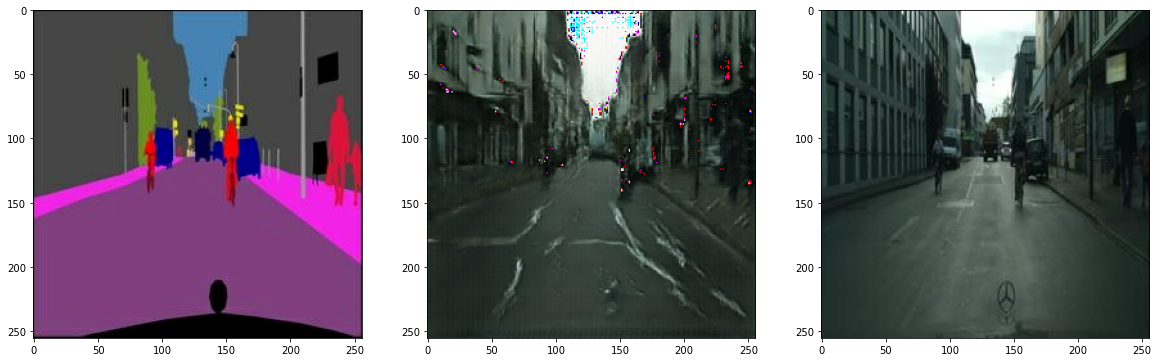

In [58]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))


# 루브릭
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
 - 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
 - U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.
 - 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.


# 회고
학습 데이터가 포켓몬과 반대로 되어 있어 이미지 입력만 반대로 바꿔주고 학습을 진행하였다. 에폭 10번, 50번, 100번에 따라 결과가 좋아짐을 알 수 있었고 200번까지는 큰 차이가 없었다. 